don't work on the same notebook
if working on the same part of the project, communicate on what is next to be done

# Project 5 (Group) -  Recidivism in Georgia x-x

## Notebook Summary
---
This contents of this notebook includes the problem statement, background research, & pre-processing/data cleaning

## Problem Statement
---

TEXT TEXT TEXT

## Background & Outside Research
---

### Project Websites
https://data.ojp.usdoj.gov/Courts/NIJ-s-Recidivism-Challenge-Full-Dataset/ynf5-u8nk 
 
https://data.ojp.usdoj.gov/stories/s/daxx-hznc
 
https://nij.ojp.gov/funding/recidivism-forecasting-challenge#g0jtto

### Datasets
---

TEXT TEXT [`datasets`](./datasets/) folder for this project that I will be using.
TEXT TEXT
* [`file.csv`](./datasets/file.csv): this dataset has the raw data collected TEXT TEXT


--- 
# Part 1 - Data Cleaning/Pre-Processing

---

In [67]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [2]:
recid_df = pd.read_csv('./data/NIJ_s_Recidivism_Challenge_Full_Dataset.csv')
recid_df.columns = [x.lower() for x in recid_df]

In [3]:
# just looking...
# recid_df[['employment_exempt','percent_days_employed','prison_offense']].head(30)

In [4]:
# recid_df.info()

In [5]:
recid_df.shape

(25835, 54)

In [6]:
recid_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,25835.0,13314.004838,7722.206327,1.0,6626.500000,13270.000000,20021.500000,26761.0
residence_puma,25835.0,12.361796,7.133742,1.0,6.000000,12.000000,18.000000,25.0
supervision_risk_score_first,25360.0,6.082216,2.381442,1.0,4.000000,6.000000,8.000000,10.0
avg_days_per_drugtest,19732.0,93.890044,117.169847,0.5,28.837366,55.424812,110.333333,1088.5
drugtests_thc_positive,20663.0,0.063350,0.138453,0.0,0.000000,0.000000,0.071429,1.0
drugtests_cocaine_positive,20663.0,0.013741,0.061233,0.0,0.000000,0.000000,0.000000,1.0
drugtests_meth_positive,20663.0,0.012890,0.060581,0.0,0.000000,0.000000,0.000000,1.0
drugtests_other_positive,20663.0,0.007550,0.041150,0.0,0.000000,0.000000,0.000000,1.0
percent_days_employed,25373.0,0.482331,0.425004,0.0,0.000000,0.475728,0.969325,1.0
jobs_per_year,25027.0,0.769295,0.813787,0.0,0.000000,0.635217,1.000000,8.0


### Outliers

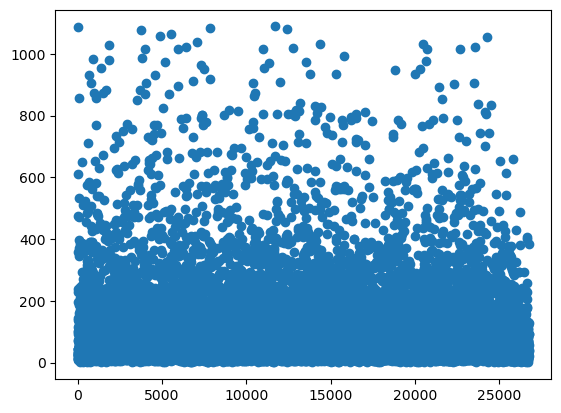

In [7]:
# avg_days_per_drugtest seems to have a large value for its max
plt.scatter(y = recid_df['avg_days_per_drugtest'], x = recid_df['id']);

#nevermind, its not a crazy outlier

### Nulls

#### Potential Ways to Handle Nulls
Note: KNN doesn't expect data to be normally distributed, but iterativeimputer does, but we have a lot of cols so it might not be super important

**pre train-test-split**
<!-- - prison_offense - 12.7% of the data - drop nulls bc this will prob be highly correlated with other cols that'll capture -->

**post train-test-split**

KNNimputer
- gang_affiliated - 12% of the data, initial thinking is to drop OR knn imputer
<!-- - drugtests_thc_positive
- drugtests_cocaine_positive
- drugtests_meth_positive
- drugtests_other_positive

Impute with Median
- avg_days_per_drugtest - we could impute with median, it's skewed very left -->

-Impute with Mean
- supervision_risk_score_first - pretty normal distribution, use mean

-Impute with most frequent
- supervision_level_first - 7% of the data - most frequent - 'Standard', use mode

-TBD - need to think about this
<!-- - percent_days_employed - employment_exempt = true then this will be 0. iterative imputer (filling in vals based on weights of the features) -->
<!-- - jobs_per_year - 3% - we could drop or if we want to keep KNNImputer. I don't think mode, mean, median will be helpful here -->

In [8]:
#checking for nulls
nulls = pd.DataFrame(recid_df.isna().sum())
nulls = nulls.loc[nulls[0] != 0]
nulls

,0
gang_affiliated,3167
supervision_risk_score_first,475
supervision_level_first,1720
prison_offense,3277
avg_days_per_drugtest,6103
drugtests_thc_positive,5172
drugtests_cocaine_positive,5172
drugtests_meth_positive,5172
drugtests_other_positive,5172
percent_days_employed,462


In [9]:
# filling in NaNs with 0 for the following columns
drug_cols = recid_df.filter(like='drugtest').columns
recid_df[drug_cols] = recid_df[drug_cols].fillna(0)

There are no 0 values so NAN must represent 0
- drugtests_thc_positive
- drugtests_cocaine_positive
- drugtests_meth_positive
- drugtests_other_positive
- avg_days_per_drugtest 

In [10]:
#drop the prison offense with NANs, not enough to justify keeping and what would be best way to immpute if we kept? 
#12.8% of the data removed

recid_df.dropna(subset ='prison_offense', inplace = True)

In [11]:
#looking at how these two cols are related
#maybe clerical differences in how work is measured. When looking at distribution we notice high vals of 0% and 1%

employ_cols = ['percent_days_employed','employment_exempt']
recid_df[employ_cols].value_counts(normalize = True)

percent_days_employed  employment_exempt
0.000000               False                0.277015
1.000000               False                0.184857
0.000000               True                 0.044317
1.000000               True                 0.020239
0.500000               False                0.000497
                                              ...   
0.420485               False                0.000045
0.420502               False                0.000045
0.420945               False                0.000045
0.421209               False                0.000045
0.629335               True                 0.000045
Length: 9815, dtype: float64

In [12]:
#drop jobs_per_year since there is a relationship to percent days employed, a better metric of employement would be percent_days regardless
recid_df.drop(columns = 'jobs_per_year',inplace = True)

#percent_days_employed is 2% of the data and would be difficult to impute since its a continuous variable
recid_df.dropna(subset = ['percent_days_employed'],inplace = True)

In [13]:
# because we dropped rows, just checking that training and test still have a 70-30 split
recid_df['training_sample'].value_counts(normalize=True)

1    0.697009
0    0.302991
Name: training_sample, dtype: float64

#### Looking at distribution of cols with Nulls to decide how to handle

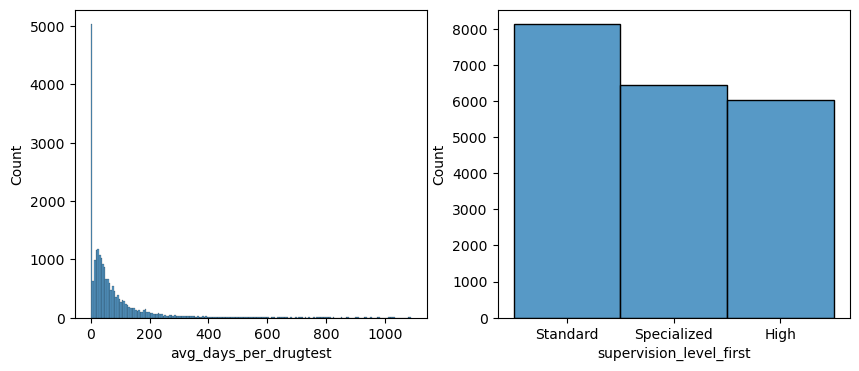

In [14]:
#create subplots
fig, ax = plt.subplots(1,2,figsize = (10,4))

sns.histplot(data=recid_df,x='avg_days_per_drugtest', ax=ax[0])
sns.histplot(data=recid_df,x='supervision_level_first', ax=ax[1]);

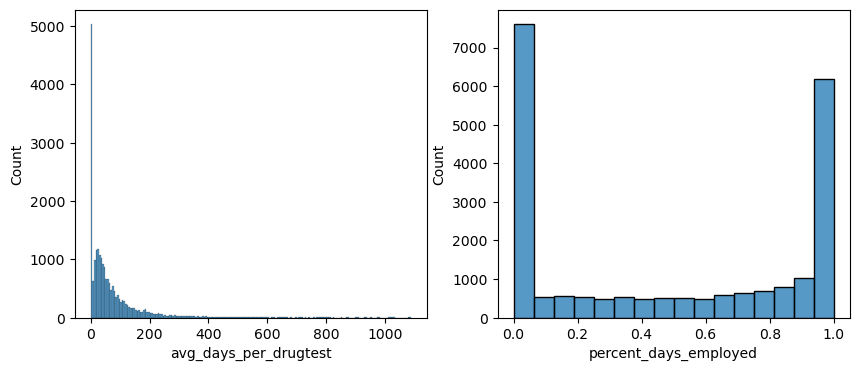

In [15]:
fig, ax = plt.subplots(1,2,figsize = (10,4))

sns.histplot(data=recid_df,x='avg_days_per_drugtest', ax=ax[0])
sns.histplot(data=recid_df,x='percent_days_employed', ax=ax[1]);

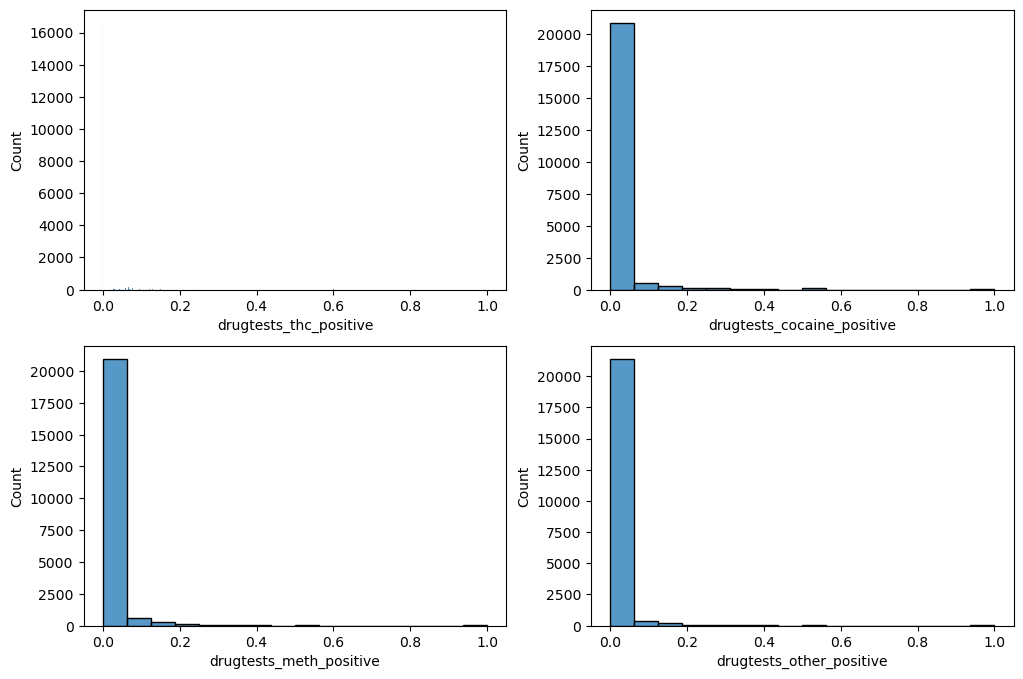

In [16]:
fig, ax = plt.subplots(2,2,figsize = (12,8))

sns.histplot(data=recid_df,x='drugtests_thc_positive', ax=ax[0,0])
sns.histplot(data=recid_df,x='drugtests_cocaine_positive', ax=ax[0,1])
sns.histplot(data=recid_df,x='drugtests_meth_positive', ax=ax[1,0])
sns.histplot(data=recid_df,x='drugtests_other_positive', ax=ax[1,1]);

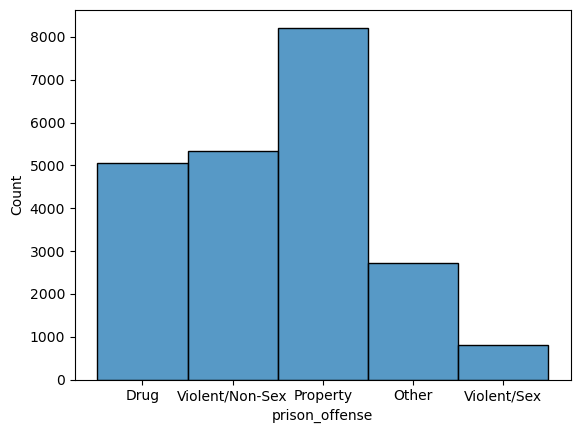

In [17]:
sns.histplot(data=recid_df,x='prison_offense');

In [18]:
# objects_df = recid_df.select_dtypes(include = 'object')
# numeric_df = recid_df.select_dtypes(include = ['float64','int64'])
# bool_df = recid_df.select_dtypes(include = ['bool'])

In [19]:
# print(objects_df.shape)
# print(numeric_df.shape)
# print(bool_df.shape)

## Binary Columns to Numeric

In [20]:
#checking for nulls - no nulls!
# bool_df.isna().sum()

In [21]:
#converting booleans to binary values true 1- false 0
for cols in recid_df.select_dtypes(include = ['bool']).columns:
    recid_df[cols].replace({True: 1, False: 0}, inplace=True)

In [22]:
#convert M to 1 and F to 0  for gender
recid_df['gender'].replace({'M': 1, 'F': 0}, inplace=True)

In [23]:
#convert BLACK to 1 and WHITE to 0  for race
recid_df['race'].replace({'BLACK': 1, 'WHITE': 0}, inplace=True)

#### Converting 'Dependents' from ordinal to Binary/Numeric

In [24]:
#converting '2' and '3 or more' to 1
recid_df['dependents'].replace({'0': 0, '1': 1, '2': 1, '3 or more': 1}, inplace=True)
recid_df.rename({'dependents': 'has_dependents'}, inplace=True)

In [25]:
recid_df.head()

,id,gender,race,age_at_release,residence_puma,gang_affiliated,supervision_risk_score_first,supervision_level_first,education_level,dependents,...,drugtests_cocaine_positive,drugtests_meth_positive,drugtests_other_positive,percent_days_employed,employment_exempt,recidivism_within_3years,recidivism_arrest_year1,recidivism_arrest_year2,recidivism_arrest_year3,training_sample
0,1,1,1,43-47,16,False,3.0,Standard,At least some college,1,...,0.0,0.000000,0.0,0.488562,0,0,0,0,0,1
1,2,1,1,33-37,16,False,6.0,Specialized,Less than HS diploma,1,...,0.0,0.000000,0.0,0.425234,0,1,0,0,1,1
2,3,1,1,48 or older,24,False,7.0,High,At least some college,1,...,0.0,0.166667,0.0,0.000000,0,1,0,1,0,1
3,4,1,0,38-42,16,False,7.0,High,Less than HS diploma,1,...,0.0,0.000000,0.0,1.000000,0,0,0,0,0,1
4,5,1,0,33-37,16,False,4.0,Specialized,Less than HS diploma,1,...,0.0,0.058824,0.0,0.203562,0,1,1,0,0,1


## Train and Test Split

In [26]:
# the data was already split into train_test_split, confirming it's still a 70-30 split
recid_df['training_sample'].value_counts(normalize=True)

1    0.697009
0    0.302991
Name: training_sample, dtype: float64

In [27]:
train = recid_df.loc[recid_df['training_sample'] == 1]
test = recid_df.loc[recid_df['training_sample'] == 0]

In [28]:
train.shape

(15429, 53)

In [29]:
train.head(2)

,id,gender,race,age_at_release,residence_puma,gang_affiliated,supervision_risk_score_first,supervision_level_first,education_level,dependents,...,drugtests_cocaine_positive,drugtests_meth_positive,drugtests_other_positive,percent_days_employed,employment_exempt,recidivism_within_3years,recidivism_arrest_year1,recidivism_arrest_year2,recidivism_arrest_year3,training_sample
0,1,1,1,43-47,16,False,3.0,Standard,At least some college,1,...,0.0,0.0,0.0,0.488562,0,0,0,0,0,1
1,2,1,1,33-37,16,False,6.0,Specialized,Less than HS diploma,1,...,0.0,0.0,0.0,0.425234,0,1,0,0,1,1


In [30]:
test.shape

(6707, 53)

In [31]:
test.head(2)

,id,gender,race,age_at_release,residence_puma,gang_affiliated,supervision_risk_score_first,supervision_level_first,education_level,dependents,...,drugtests_cocaine_positive,drugtests_meth_positive,drugtests_other_positive,percent_days_employed,employment_exempt,recidivism_within_3years,recidivism_arrest_year1,recidivism_arrest_year2,recidivism_arrest_year3,training_sample
5,6,1,0,38-42,17,False,5.0,Standard,High School Diploma,0,...,0.0,0.0,0.0,0.674252,0,0,0,0,0,0
7,8,1,1,38-42,16,False,5.0,High,High School Diploma,1,...,0.0,0.0,0.0,0.469446,0,0,0,0,0,0


In [32]:
#drop targets & training_sample col from train/test df & reassign to new df
X_train_df = train.drop(columns = ['recidivism_within_3years','recidivism_arrest_year1', 'recidivism_arrest_year2', 'recidivism_arrest_year3', 'training_sample'])
X_test_df = test.drop(columns = ['recidivism_within_3years','recidivism_arrest_year1', 'recidivism_arrest_year2', 'recidivism_arrest_year3', 'training_sample'])

In [33]:
X_train_df.head(2)

,id,gender,race,age_at_release,residence_puma,gang_affiliated,supervision_risk_score_first,supervision_level_first,education_level,dependents,...,program_attendances,program_unexcusedabsences,residence_changes,avg_days_per_drugtest,drugtests_thc_positive,drugtests_cocaine_positive,drugtests_meth_positive,drugtests_other_positive,percent_days_employed,employment_exempt
0,1,1,1,43-47,16,False,3.0,Standard,At least some college,1,...,6,0,2,612.000000,0.0,0.0,0.0,0.0,0.488562,0
1,2,1,1,33-37,16,False,6.0,Specialized,Less than HS diploma,1,...,0,0,2,35.666667,0.0,0.0,0.0,0.0,0.425234,0


In [34]:
y_train = train[['id','recidivism_within_3years']]
y_test = test[['id','recidivism_within_3years']]


#if we want to use the recidivism_arrest_yearX for a separate model
y_train2 = train[['id', 'recidivism_arrest_year1', 'recidivism_arrest_year2', 'recidivism_arrest_year3']]
y_test2 = test[['id','recidivism_arrest_year1', 'recidivism_arrest_year2', 'recidivism_arrest_year3']]

## Impute Missing Values

## Train

### Impute supervision_risk_score_first (mean) & supervision_level_first (mode)

In [35]:
# impute 'supervision_risk_score_first' with mean and 'supervision_level_first' with most frequent using a transformer

imputer1 = SimpleImputer(strategy='mean')
imputer2 = SimpleImputer(strategy="most_frequent")

imputer = make_column_transformer((imputer1,['supervision_risk_score_first']),
                                  (imputer2,['supervision_level_first']),
                                  remainder='passthrough',
                                  verbose_feature_names_out=False)

In [36]:
#fit & transform train
imputer.fit_transform(X_train_df)

array([[3.0, 'Standard', 1, ..., 0.0, 0.488562092, 0],
       [6.0, 'Specialized', 2, ..., 0.0, 0.425233645, 0],
       [7.0, 'High', 3, ..., 0.0, 0.0, 0],
       ...,
       [3.0, 'Standard', 26731, ..., 0.0, 1.0, 0],
       [4.0, 'Standard', 26734, ..., 0.0, 0.574742268, 0],
       [3.0, 'Standard', 26743, ..., 0.0, 0.181518152, 0]], dtype=object)

In [37]:
#convert to df
X_train_df_imp = pd.DataFrame(imputer.fit_transform(X_train_df), columns= imputer.get_feature_names_out(), index=X_train_df.index)

In [38]:
#apply transformer to test df
imputer.fit_transform(X_test_df)

array([[5.0, 'Standard', 6, ..., 0.0, 0.674252002, 0],
       [5.0, 'High', 8, ..., 0.0, 0.469446441, 0],
       [5.0, 'Specialized', 12, ..., 0.0, 0.0, 1],
       ...,
       [6.0, 'Standard', 26680, ..., 0.0, 0.163793103, 0],
       [7.0, 'Standard', 26681, ..., 0.13333334, 0.344155844, 0],
       [8.0, 'Standard', 26701, ..., 0.0, 0.0, 0]], dtype=object)

In [39]:
X_test_df_imp = pd.DataFrame(imputer.fit_transform(X_test_df), columns= imputer.get_feature_names_out(), index=X_test_df.index)
X_test_df_imp.head()

,supervision_risk_score_first,supervision_level_first,id,gender,race,age_at_release,residence_puma,gang_affiliated,education_level,dependents,...,program_attendances,program_unexcusedabsences,residence_changes,avg_days_per_drugtest,drugtests_thc_positive,drugtests_cocaine_positive,drugtests_meth_positive,drugtests_other_positive,percent_days_employed,employment_exempt
5,5.0,Standard,6,1,0,38-42,17,False,High School Diploma,0,...,0,0,3 or more,474.6,0.0,0.0,0.0,0.0,0.674252,0
7,5.0,High,8,1,1,38-42,16,False,High School Diploma,1,...,0,0,0,34.775,0.0,0.0,0.0,0.0,0.469446,0
11,5.0,Specialized,12,1,1,33-37,16,False,High School Diploma,1,...,10 or more,0,0,8.04,0.04,0.0,0.08,0.0,0.0,1
14,7.0,Standard,15,1,0,33-37,5,False,Less than HS diploma,1,...,6,0,1,98.75,0.0,0.0,0.0,0.0,0.0,1
22,4.0,Standard,23,0,0,48 or older,5,NaN,High School Diploma,0,...,6,0,0,15.5,0.0,0.0,0.055556,0.0,0.0,0


### Encode Categorical Columns
Need this done before KNN can happen

'gang_affiliated'

OHE
- 'age_at_release'
- 'supervision_level_first'
- 'education_level'
- 'prison_offense'
- 'prison_years'

Convert to Numeric - Ordinal
- 'prior_arrest_episodes_felony'
- 'prior_arrest_episodes_misd'
- 'prior_arrest_episodes_violent'
- 'prior_arrest_episodes_property'
- 'prior_arrest_episodes_drug'
- 'prior_arrest_episodes_ppviolationcharges'
- 'prior_conviction_episodes_felony'
- 'prior_conviction_episodes_misd',
- 'prior_conviction_episodes_prop'
- 'prior_conviction_episodes_drug',
- 'delinquency_reports'
- 'program_unexcusedabsences'
- 'residence_changes'

In [40]:
#unique vals for cols to turn to ordinal vals
cols_to_numeric = ['prior_arrest_episodes_felony',
                   'prior_arrest_episodes_misd',
                   'prior_arrest_episodes_violent',
                   'prior_arrest_episodes_property',
                   'prior_arrest_episodes_drug',
                   'prior_arrest_episodes_ppviolationcharges',
                   'prior_conviction_episodes_felony',
                   'prior_conviction_episodes_misd',
                   'prior_conviction_episodes_prop',
                   'prior_conviction_episodes_drug',
                   'delinquency_reports',
                   'program_unexcusedabsences',
                   'program_attendances', #DS added this one in
                   'residence_changes']  #DS added this one in

[print(col, X_train_df_imp[col].unique()) for col in cols_to_numeric]

prior_arrest_episodes_felony ['6' '7' '8' '4' '10 or more' '3' '9' '5' '2' '1' '0']
prior_arrest_episodes_misd ['6 or more' '4' '3' '5' '2' '0' '1']
prior_arrest_episodes_violent ['1' '3 or more' '0' '2']
prior_arrest_episodes_property ['3' '0' '2' '5 or more' '1' '4']
prior_arrest_episodes_drug ['3' '2' '1' '5 or more' '0' '4']
prior_arrest_episodes_ppviolationcharges ['4' '5 or more' '3' '1' '2' '0']
prior_conviction_episodes_felony ['3 or more' '1' '2' '0']
prior_conviction_episodes_misd ['3' '4 or more' '2' '0' '1']
prior_conviction_episodes_prop ['2' '0' '1' '3 or more']
prior_conviction_episodes_drug ['2 or more' '1' '0']
delinquency_reports ['0' '4 or more' '3' '2' '1']
program_unexcusedabsences ['0' '2' '1' '3 or more']
program_attendances ['6' '0' '7' '9' '10 or more' '1' '4' '3' '5' '2' '8']
residence_changes ['2' '0' '3 or more' '1']


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [41]:
# strip 'or more' from all vals from the cols above
for c in cols_to_numeric:
    X_train_df_imp[c] = X_train_df_imp[c].str.strip(' or more')

In [42]:
#checking that changes were made
X_train_df_imp['prior_arrest_episodes_misd'].unique()

array(['6', '4', '3', '5', '2', '0', '1'], dtype=object)

In [43]:
#converting these columns to numeric
for c in cols_to_numeric:
    X_train_df_imp[c] = pd.to_numeric(X_train_df_imp[c])

In [44]:
#checking that changes were made
X_train_df_imp['prior_arrest_episodes_misd'].dtype

dtype('int64')

In [45]:
# strip 'or more' from all vals from the cols above
for c in cols_to_numeric:
    X_test_df_imp[c] = X_test_df_imp[c].str.strip(' or more')

In [46]:
#checking that changes were made
X_test_df_imp['prior_arrest_episodes_misd'].unique()

array(['0', '6', '1', '3', '4', '2', '5'], dtype=object)

In [47]:
#converting these columns to numeric
for c in cols_to_numeric:
    X_test_df_imp[c] = pd.to_numeric(X_test_df_imp[c])

In [48]:
#checking that changes were made
X_test_df_imp['prior_arrest_episodes_misd'].dtype

dtype('int64')

### Converting select object columns to numeric

In [49]:
X_train_df_imp.select_dtypes(['object']).columns

Index(['supervision_risk_score_first', 'supervision_level_first', 'id',
       'gender', 'race', 'age_at_release', 'residence_puma', 'gang_affiliated',
       'education_level', 'dependents', 'prison_offense', 'prison_years',
       'prior_arrest_episodes_dvcharges', 'prior_arrest_episodes_guncharges',
       'prior_conviction_episodes_viol',
       'prior_conviction_episodes_ppviolationcharges',
       'prior_conviction_episodes_domesticviolencecharges',
       'prior_conviction_episodes_guncharges', 'prior_revocations_parole',
       'prior_revocations_probation', 'condition_mh_sa', 'condition_cog_ed',
       'condition_other', 'violations_electronicmonitoring',
       'violations_instruction', 'violations_failtoreport',
       'violations_movewithoutpermission', 'avg_days_per_drugtest',
       'drugtests_thc_positive', 'drugtests_cocaine_positive',
       'drugtests_meth_positive', 'drugtests_other_positive',
       'percent_days_employed', 'employment_exempt'],
      dtype='object'

In [50]:
#changing incorrect dtypes for cols from obj to numeric

obj_to_numeric = ['gender', 'race', 'dependents', 'prior_arrest_episodes_dvcharges', 'prior_arrest_episodes_guncharges',
       'prior_conviction_episodes_viol',
       'prior_conviction_episodes_ppviolationcharges',
       'prior_conviction_episodes_domesticviolencecharges',
       'prior_conviction_episodes_guncharges', 'prior_revocations_parole',
       'prior_revocations_probation', 'condition_mh_sa', 'condition_cog_ed',
       'condition_other', 'violations_electronicmonitoring',
       'violations_instruction', 'violations_failtoreport',
       'violations_movewithoutpermission','employment_exempt', 'avg_days_per_drugtest',
       'drugtests_thc_positive', 'drugtests_cocaine_positive',
       'drugtests_meth_positive', 'drugtests_other_positive',
       'percent_days_employed', 'supervision_risk_score_first']

In [51]:
#converting these columns to numeric on train/test
for c in obj_to_numeric:
    X_train_df_imp[c] = pd.to_numeric(X_train_df_imp[c])
    
for c in obj_to_numeric:
    X_test_df_imp[c] = pd.to_numeric(X_test_df_imp[c])

In [52]:
#going to convert into integers based on what the data dict says - should be 1-10 score
X_train_df_imp['supervision_risk_score_first'].value_counts(normalize=True)

6.000000     0.149135
7.000000     0.143172
5.000000     0.130015
8.000000     0.114913
4.000000     0.107719
9.000000     0.100395
10.000000    0.088211
3.000000     0.080109
2.000000     0.044980
1.000000     0.021972
6.154461     0.019379
Name: supervision_risk_score_first, dtype: float64

In [53]:
X_train_df_imp['supervision_risk_score_first'] = X_train_df_imp['supervision_risk_score_first'].astype(int)
X_test_df_imp['supervision_risk_score_first'] = X_test_df_imp['supervision_risk_score_first'].astype(int)
# X_train_df_imp['supervision_risk_score_first'].value_counts(normalize=True)

#### KNN Imputer: Gang Affilated
- categorical columns need to be numeric or encoded before imputing
- Scale all numerical columns but: residence_puma, id

In [54]:
X_train_df_imp.select_dtypes(['object']).head(3)

,supervision_level_first,id,age_at_release,residence_puma,gang_affiliated,education_level,prison_offense,prison_years
0,Standard,1,43-47,16,False,At least some college,Drug,More than 3 years
1,Specialized,2,33-37,16,False,Less than HS diploma,Violent/Non-Sex,More than 3 years
2,High,3,48 or older,24,False,At least some college,Drug,1-2 years


In [55]:
X_test_df_imp.select_dtypes(['object']).head(3)

,supervision_level_first,id,age_at_release,residence_puma,gang_affiliated,education_level,prison_offense,prison_years
5,Standard,6,38-42,17,False,High School Diploma,Property,More than 3 years
7,High,8,38-42,16,False,High School Diploma,Drug,Greater than 2 to 3 years
11,Specialized,12,33-37,16,False,High School Diploma,Other,1-2 years


### OHE Select Categorical Columns

In [56]:
#instantiate OHE
ohe = OneHotEncoder(sparse=False, drop='if_binary')

#list of cols to dummy
cols_to_ohe = ['age_at_release',
               'supervision_level_first',
               'education_level',
               'prison_offense',
               'prison_years']

#create transformer to apply OHE to select ols only
transformer = make_column_transformer((ohe, cols_to_ohe),
                                      remainder = 'passthrough',
                                      verbose_feature_names_out = False)

In [57]:
transformer.fit_transform(X_train_df_imp)
transformer.transform(X_test_df_imp)

array([[0.0, 0.0, 0.0, ..., 0.0, 0.674252002, 0],
       [0.0, 0.0, 0.0, ..., 0.0, 0.469446441, 0],
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 1],
       ...,
       [0.0, 0.0, 1.0, ..., 0.0, 0.163793103, 0],
       [0.0, 1.0, 0.0, ..., 0.13333334, 0.344155844, 0],
       [0.0, 1.0, 0.0, ..., 0.0, 0.0, 0]], dtype=object)

In [58]:
#convert to dataframe
X_train_encoded = pd.DataFrame(transformer.fit_transform(X_train_df_imp), columns = transformer.get_feature_names_out(), index=X_train_df_imp.index)
X_test_encoded = pd.DataFrame(transformer.transform(X_test_df_imp), columns = transformer.get_feature_names_out(), index=X_test_df_imp.index)

### Scale Data

In [74]:
#instantiate sc
sc = StandardScaler()

#list of cols
cols_to_scale = X_train_encoded.drop(columns=['id','residence_puma', 'gang_affiliated']).columns.values

#create transformer to apply OHE to select ols only
scaler = make_column_transformer((sc, cols_to_scale),
                                 remainder = 'passthrough',
                                 verbose_feature_names_out = False)

In [76]:
#fit transform 
Z_train = scaler.fit_transform(X_train_encoded)
Z_test = scaler.transform(X_test_encoded)

#turn into df
Z_train = pd.DataFrame(Z_train, columns=scaler.get_feature_names_out(), index=X_train_encoded.index)
Z_test = pd.DataFrame(Z_test, columns=scaler.get_feature_names_out(), index=X_test_encoded.index)

### KNNImputer for 'gang_affiliated' Nulls

In [81]:
#instantiate KNNImputer
knn_imp = KNNImputer()

X_train_knn = knn_imp.fit_transform(Z_train)

#convert to df
X_train_knn = pd.DataFrame(X_train_knn,columns = Z_train.columns, index=Z_train.index)

#checking that nulls were filled in
X_train_knn['gang_affiliated'].isna().sum()

0

In [82]:
#instantiate KNNImputer
knn_imp2 = KNNImputer()

X_test_knn = knn_imp2.fit_transform(Z_test)

#convert to df
X_test_knn = pd.DataFrame(X_test_knn,columns = Z_test.columns, index=Z_test.index)

#checking that nulls were filled in
X_test_knn['gang_affiliated'].isna().sum()

0

In [83]:
#rounding vals for 'gang_affiliated' col
X_train_knn['gang_affiliated'] = X_train_knn[['gang_affiliated']].round()
X_test_knn['gang_affiliated'] = X_test_knn[['gang_affiliated']].round()

In [84]:
X_train_knn.head()

,age_at_release_18-22,age_at_release_23-27,age_at_release_28-32,age_at_release_33-37,age_at_release_38-42,age_at_release_43-47,age_at_release_48 or older,supervision_level_first_High,supervision_level_first_Specialized,supervision_level_first_Standard,...,avg_days_per_drugtest,drugtests_thc_positive,drugtests_cocaine_positive,drugtests_meth_positive,drugtests_other_positive,percent_days_employed,employment_exempt,id,residence_puma,gang_affiliated
0,-0.295491,-0.502045,-0.48131,-0.441200,-0.354558,2.909578,-0.420153,-0.614483,-0.640670,1.139914,...,4.922330,-0.398177,-0.200406,-0.194036,-0.162822,0.016395,-0.399112,1.0,16.0,0.0
1,-0.295491,-0.502045,-0.48131,2.266546,-0.354558,-0.343692,-0.420153,-0.614483,1.560866,-0.877259,...,-0.331993,-0.398177,-0.200406,-0.194036,-0.162822,-0.132771,-0.399112,2.0,16.0,0.0
2,-0.295491,-0.502045,-0.48131,-0.441200,-0.354558,-0.343692,2.380083,1.627384,-0.640670,-0.877259,...,0.196782,2.221204,-0.200406,2.913829,-0.162822,-1.134383,-0.399112,3.0,24.0,0.0
3,-0.295491,-0.502045,-0.48131,-0.441200,2.820413,-0.343692,-0.420153,1.627384,-0.640670,-0.877259,...,-0.425592,-0.398177,-0.200406,-0.194036,-0.162822,1.221056,-0.399112,4.0,16.0,0.0
4,-0.295491,-0.502045,-0.48131,2.266546,-0.354558,-0.343692,-0.420153,-0.614483,1.560866,-0.877259,...,-0.446400,-0.398177,-0.200406,0.902857,-0.162822,-0.654904,-0.399112,5.0,16.0,0.0


In [88]:
## Scale 'gang_affiliated' column

#instantiate sc
sc2 = StandardScaler()

#list of cols
cols_to_scale = X_train_knn.drop(columns=['id','residence_puma']).columns.values

#create transformer to apply OHE to select ols only
scaler2 = make_column_transformer((sc2, cols_to_scale),
                                 remainder = 'passthrough',
                                 verbose_feature_names_out = False)


In [90]:
#fit transform 
X_train_final = scaler2.fit_transform(X_train_knn)
X_test_final = scaler2.transform(X_test_knn)

#turn into df
X_train_final = pd.DataFrame(X_train_final, columns=scaler2.get_feature_names_out(), index=X_train_knn.index)
X_test_final = pd.DataFrame(X_test_final, columns=scaler2.get_feature_names_out(), index=X_test_knn.index)

In [96]:
#Export to csv
X_train_final.to_csv('./cleaned_data/X_train_final.csv')
X_test_final.to_csv('./cleaned_data/X_test_final.csv')
y_train.to_csv('./cleaned_data/y_train.csv')
y_test.to_csv('./cleaned_data/y_test.csv')

### Correlations

In [93]:
# #plot correlation of features to target val
# plt.figure(figsize=(6,12))
# sns.heatmap(pd.merge(X_train_knn, y_train, on='id').corr()[['recidivism_within_3years']].sort_values('recidivism_within_3years', ascending=False),
#             annot=True);